### Load Dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
import pandas as pd 
import tensorflow as tf
from bs4 import BeautifulSoup
import re
import matplotlib.pyplot as plt
import nltk

In [3]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full

In [5]:
from nltk.corpus import stopwords,wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer

### Load Dataset

In [6]:
data=pd.read_csv('https://raw.githubusercontent.com/varun-pradhan-117/tweet-classification/main/datasets/tweets.csv')

### Since it might affect final outcome, a few words are removed from stopwords list

In [7]:
#get stopword list
sw_list=stopwords.words('english')

#Since it might affect final outcome, a few words are removed from stopwords list
sw_list.remove('not')
sw_list.remove('no')
sw_list.remove('against')

In [8]:
#Initialize lemmatizer
lemmatizer=WordNetLemmatizer()

### Clean dataset

In [9]:
#Get nltk tag for lemmatizing a given token
def nltk_wn_tag(nltk_tag):
  if nltk_tag.startswith('J'):
    return wordnet.ADJ
  elif nltk_tag.startswith('V'):
    return wordnet.VERB
  elif nltk_tag.startswith('N'):
    return wordnet.NOUN
  elif nltk_tag.startswith('R'):
    return wordnet.ADV
  else:                    
    return None

In [10]:
# Function to lemmatize a sentence
def lemmatize_sentence(sentence):
    tagged = nltk.pos_tag(nltk.word_tokenize(sentence))
    wordnet_tagged = map(lambda x: (x[0], nltk_wn_tag(x[1])), tagged)
    lemmatized_words=[]
    for word, tag in wordnet_tagged:
        if word not in sw_list:
            if tag is None:                        
                lemmatized_words.append(word)
            else:
                lemmatized_words.append(lemmatizer.lemmatize(word, tag))
    return " ".join(lemmatized_words)
    

In [11]:
def clean_tweets(tweet):
    #remove RT(retweet tag)
    tweet=re.sub(r"RT @","@",tweet)
    #remove pings
    tweet = re.sub(r"@[A-Za-z0-9]+", ' ', tweet)
    #remove URLs
    tweet = re.sub(r"https?://[A-Za-z0-9./]+", ' ', tweet)
    #remove special characters
    tweet = re.sub(r"[^a-zA-Z]", ' ', tweet)
    #convert to lower case
    tweet=tweet.lower()
    #remove extra white spaces
    tweet = re.sub(r" +",' ', tweet)
    #lemmatization of tweet and removing stopwords
    lemmatized_tweet=lemmatize_sentence(tweet)
    #remove extra white spaces
    tweet = re.sub(r" +", ' ', tweet)
    return lemmatized_tweet.strip()

In [12]:
data['tweets']=[clean_tweets(tweet) for tweet in data['tweets']]

### Train Test Split

In [13]:
from sklearn.model_selection import train_test_split
X=data['tweets']
y=data['labels']
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=7)

### Getting TF-IDF weighted embeddings

#### Import spacy

In [14]:
import spacy

nlp  = spacy.load('en_core_web_sm')

In [15]:
X_train

534     campaign fundraiser tonight pres obama denounc...
1135                               next day obama order u
707     think top secret obama world war illuminati an...
1051    shecallsmelarrythe new anti obama slur rwnj ec...
389     american kid uk ohhh cool tea queen british ki...
                              ...                        
211     mean saving scotus tell world obama wrong aca ...
502     romney gon na nominee not first choice either ...
537     occupywallst whatsromneyhiding umm guarantee a...
1220    obama campaign say romney make public year tax...
175     en el backstage de los kca harry le pregunto m...
Name: tweets, Length: 1091, dtype: object

#### Get tokenized list of tweets in training set

In [16]:
tweets=[word_tokenize(tweet) for tweet in X_train]

#### Import gensim and initialize dictionary on training set

In [17]:
from gensim.corpora import Dictionary
from gensim.models.tfidfmodel import TfidfModel
from gensim.matutils import sparse2full
tweet_dict=Dictionary(tweets) 
tweet_dict.compactify() 

#### Create a corpus using training Data and initialize a TF-IDF model on the corpus

In [18]:
corpus = [tweet_dict.doc2bow(tweet) for tweet in tweets]
model_tfidf = TfidfModel(corpus, id2word=tweet_dict)

#### Create bag of words model of training set and get TF-IDF values for the training data

In [19]:
train_corpus=[tweet_dict.doc2bow(word_tokenize(tweet)) for tweet in X_train]
train_tfidf  = model_tfidf[train_corpus]
# Get TF-IDF vectors for training data
train_vecs   = np.vstack([sparse2full(c, len(tweet_dict)) for c in train_tfidf])

#### Use spacy to get Glove embedding for each TF-IDF term

In [20]:
tfidf_emb_tweet_vecs = np.vstack([nlp(tweet_dict[i]).vector for i in range(len(tweet_dict))])

#### Get TF-IDF weighted glove vector for each document by matrix multiplication

In [21]:
train_emb = np.dot(train_vecs, tfidf_emb_tweet_vecs) 

#### Repeat Process for test data

In [22]:
test_corpus=[tweet_dict.doc2bow(word_tokenize(tweet)) for tweet in X_test]
test_tfidf=model_tfidf[test_corpus]
test_vecs=np.vstack([sparse2full(c,len(tweet_dict)) for c in test_tfidf])
test_emb=np.dot(test_vecs,tfidf_emb_tweet_vecs)

### Convert label data into categorical format

In [23]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train,3)
y_test=to_categorical(y_test,3)

### Create and fit model

In [24]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout

In [25]:
model=Sequential()
model.add(Dense(activation='relu',units=64))
model.add(Dropout(0.2))
model.add(Dense(activation='relu',units=32))
model.add(Dense(activation='softmax',units=3))
model.compile(optimizer='rmsprop',loss='categorical_crossentropy',metrics=['accuracy'])

In [26]:
history=model.fit(x=train_emb,y=y_train,epochs=20, validation_data=(test_emb,y_test))

Epoch 1/20
35/35 [==============================] - 1s 8ms/step - loss: 1.2395 - accuracy: 0.6013 - val_loss: 0.9131 - val_accuracy: 0.4725
Epoch 2/20
35/35 [==============================] - 0s 3ms/step - loss: 0.8946 - accuracy: 0.6315 - val_loss: 0.8226 - val_accuracy: 0.5934
Epoch 3/20
35/35 [==============================] - 0s 3ms/step - loss: 0.8170 - accuracy: 0.6489 - val_loss: 0.7823 - val_accuracy: 0.6593
Epoch 4/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7804 - accuracy: 0.6856 - val_loss: 0.7942 - val_accuracy: 0.6520
Epoch 5/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7519 - accuracy: 0.6948 - val_loss: 0.7478 - val_accuracy: 0.6667
Epoch 6/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7075 - accuracy: 0.6984 - val_loss: 0.7399 - val_accuracy: 0.6740
Epoch 7/20
35/35 [==============================] - 0s 3ms/step - loss: 0.7028 - accuracy: 0.7195 - val_loss: 0.7399 - val_accuracy: 0.6886
Epoch 8/20
35/35 [==

### Evaluating Model

In [27]:
y_predictions=(model.predict(test_emb) > 0.5).astype("int32")

In [28]:
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score

#### Display classification report

In [29]:
print(classification_report(y_test,y_predictions))

              precision    recall  f1-score   support

           0       0.75      0.93      0.83       177
           1       0.78      0.40      0.53        80
           2       0.00      0.00      0.00        16

   micro avg       0.76      0.72      0.74       273
   macro avg       0.51      0.44      0.45       273
weighted avg       0.72      0.72      0.70       273
 samples avg       0.72      0.72      0.72       273



#### Get accuracy score on test data

In [30]:
print(accuracy_score(y_test,y_predictions))

0.7216117216117216


In [31]:
confusion_matrix(y_test.argmax(axis=1),y_predictions.argmax(axis=1))

array([[172,   5,   0],
       [ 48,  32,   0],
       [ 12,   4,   0]])

#### Plot losses

In [32]:
losses=pd.DataFrame(history.history)

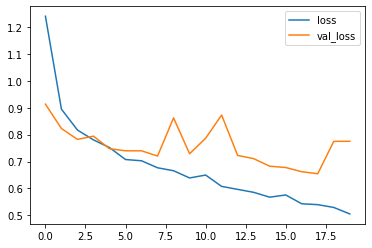

In [33]:
losses[['loss','val_loss']].plot()

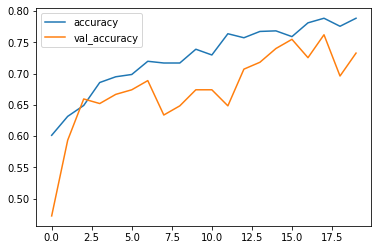

In [34]:
losses[['accuracy','val_accuracy']].plot()